# Spitogatos Assignment

    author: Georgios Galvas
    date:   10/04/2023

<a id="0"></a> <br>

### Table of Contents  
01. [Initial Data Cleaning and Pre-processing](#2)
02. [Question 01](#3)
03. [Question 02](#4)
04. [Question 03](#5)
    - [Feature Exploration](#feature_exploration)
    - [Feature Engineering](#feature_engineering)
    - [Model training](#train_models)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read dataset:
data = pd.read_csv('data/assignment_rev2.csv')

In [2]:
data.shape

(15447, 56)

## Initial Data Cleaning & Pre-processing <a class="anchor" id="2"></a>

The main steps for cleaning and preparing the dataset are the following:

- Remove Duplicates (Finding a way to detect them)
- Treat Missing Values (Imputation or Deletion)
- Remove Unrealistic/Wrong values
- Detect and Treat Outliers (Trimming or Capping)

#### How to find the duplicate house listings?

As mentioned on the assignment's description, it is possible that a house listing is present more than once on the dataset, with a different `id`, as it may have been registered by different agents. 

As a first step, we are going to check if there are duplicate houses, i.e. houses with the same 'characteristics' / features, by ignoring the house's `id` and `agent_id`. 

From below we see that no duplicates were found, since the dataset continues to have the same number of rows after dropping the duplicates. 

In [3]:
same_nrows = data.drop(['id', 'agent_id'], axis=1).drop_duplicates().shape[0]==data.shape[0]
print(f"Same #rows after duplicate deletion: \t{same_nrows}")

Same #rows after duplicate deletion: 	True


This could be explained as follows:

Assuming that there is at least one house present in the dataset more than once, it could have been that it was registered with at least one different characteristic (feature) by different agents. For example, it could be that different agents registered the same house with a slightly different price. Or one agent registered whether the house has a `fireplace` and another agent left this field empty, (maybe from pure boredom) occuring to a missing value. That is a possible explanation on why there were not duplicates found. 

A way to tackle this is to check for duplicates by taking a subset of the features/characteristics of the houses, preferably features that are not on the judgement of an agent, but are unarguable, those that would have been written on the property contract of the house. For example the `sq_meters` of a house could not be given different by different agents, as it is written on the property contract. Furthermore, the `floor` or `number of rooms` of a house are characteristics that could not have different values filled by different agents.

Finally, from this subset we will also exclude the Boolean/utilities characteristics, since they have many missing values. In  general it is better to avoid including features with missing values on this subset.

#### Analyzing the impact on the dataset when removing duplicates considering different subsets

In [4]:
def remove_duplicates(df, features):
    '''
    Removes the duplicates from a dataframe considering the 'features'. 
    Returns the indeces of the dataframe that remained.
    '''
    
    df_no_duplicates = df.drop_duplicates(subset=features)
    nrows_removed = df.shape[0] - df_no_duplicates.shape[0]
        
    print(f"Rows removed:         {nrows_removed}")
    print(f"Percentage removed:   {round(100*nrows_removed/df.shape[0],2)}%")
    print()
    

# A good choice of features. We can say that the first row of the list are the most important, 
# while the second row the least important. 
features = ['subtype', 'geography_name', 'sq_meters', 'year_of_construction', 'floor', 'price',
            'rooms', 'living_rooms', 'no_of_bathrooms', 'no_of_wc', 'kitchens', 'balcony_area']

removed_features = []
for i in range(7):
    if i != 0:
        removed_features.append(features.pop())
    
    print(f"Removed features:     {removed_features}")
    remove_duplicates(data, features)
 

Removed features:     []
Rows removed:         943
Percentage removed:   6.1%

Removed features:     ['balcony_area']
Rows removed:         1166
Percentage removed:   7.55%

Removed features:     ['balcony_area', 'kitchens']
Rows removed:         1339
Percentage removed:   8.67%

Removed features:     ['balcony_area', 'kitchens', 'no_of_wc']
Rows removed:         1499
Percentage removed:   9.7%

Removed features:     ['balcony_area', 'kitchens', 'no_of_wc', 'no_of_bathrooms']
Rows removed:         1936
Percentage removed:   12.53%

Removed features:     ['balcony_area', 'kitchens', 'no_of_wc', 'no_of_bathrooms', 'living_rooms']
Rows removed:         2724
Percentage removed:   17.63%

Removed features:     ['balcony_area', 'kitchens', 'no_of_wc', 'no_of_bathrooms', 'living_rooms', 'rooms']
Rows removed:         3094
Percentage removed:   20.03%




**NOTE:** 
It is questionable whether `price` should or should not be included. It is the case that `price` is a good and sometimes unique descriptor of a house, but it is also the case that different agents register the same house with slightly different prices (for example adding an extra 5%-10% to the price anticipating that there will be a bargain by the buyer and thus the house will eventually be sold on the initial, preferred value. 

**Extra thing I would like to try:**

If two houses with the same characteristics have a difference on the price of magnitude 5% (or 10% or x%, x to be chosen) then they are considered to be the same house. 

We choose the folowing features as a subset for removing duplicates, thus removing 943 (6.1%) rows. `df` will be the dataframe without duplicates, that we will work from now on. 


In [5]:
features = ['subtype', 'geography_name', 'year_of_construction', 'sq_meters', 'floor', 'price',
            'rooms', 'living_rooms', 'no_of_bathrooms', 'no_of_wc', 'kitchens', 'balcony_area']

data.drop_duplicates(subset=features, inplace=True)
data.shape

(14504, 56)

#### Boolean features

We consider the features of the dataset that are Boolean and investigate them seperately. We can also name them **Utility features** as they describe whether a house has specific utilities or not (garage, pool, alarm, fireplace, etc).


From below we observe the following regarding the *Boolean features*:
- All of the 37 boolean features have missing values,
- The boolean feature with the most missing values has 96.3% values missing, 
- The boolean feature with the least missing values has 10.6% values missing. 

In [6]:
# Find the Boolean features: 
boolean_features = [col for col in data.columns if set(data[col].unique())==set([True,False,np.nan])]
df_utilities = data[boolean_features].copy()

# The rest of the features: 
rest_features = list(set(data.columns).difference(set(boolean_features)))
df_rest = data[rest_features].copy()

# Validation check:
len(rest_features) + len(boolean_features) == data.shape[1]

True

In [7]:
missing_bool = pd.DataFrame(100*df_utilities.isna().sum()/data.shape[0])
print(f"Min missing value on features: {round(missing_bool.min()[0], 1)}%")
print(f"Max missing value on features: {round(missing_bool.max()[0], 1)}%")

Min missing value on features: 10.8%
Max missing value on features: 96.3%


##  Question 01 <a class="anchor" id="3"></a>

<img src="pics/question_1.png" style="width: 700px;"/>

We will work with a subset of the dataset for now. 

In [8]:
# We will work with only the following features, necessary to answer Question 01:
cols1 = ['id', 'agent_id', 'geography_name', 'subtype', 'year_of_construction', 'sq_meters', 'price'] 

df1 = data.loc[:,cols1].copy()
df1['price_per_sq_meter'] = df1['price']/df1['sq_meters']

df1.head(3)

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
0,42911697,14680.000,northern sub,apartment,2005,567,200000,352.734
1,43018583,15502.000,northern sub,detached,1992,642,550000,856.698
2,39670968,9807.000,northern sub,detached,2009,320,500000,1562.500


Treat **Outliers** and **Unrealistic Values** for the following features: 

1. price    
2. sq_meters
3. price_per_sq_meter


In [9]:
# Some summary statistics: 

df1[['sq_meters', 'price', 'price_per_sq_meter']].describe().T

,count,mean,std,min,25%,50%,75%,max
sq_meters,14504.000,213.387,1177.210,1.000,90.000,143.000,255.000,140000.000
price,14504.000,607145.687,729309.672,0.000,240000.000,400000.000,750000.000,25000000.000
price_per_sq_meter,14504.000,2974.710,5740.008,0.000,1900.000,2631.579,3571.429,620000.000


It can be seen from the summary statistics above that: 
- there are unrealistic values, for example min value of price equal to zero
- there are extreme values, for example a price of 25,000,000

In [10]:
def diagnostic_plots(df, feature):
    '''
    Builds three plots in order to help understand the distribution of the data.
        1. Histogram
        2. Probability plot (or QQ-plot, for checking the distribution)
        3. Boxplot
    '''
    
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    #fig.suptitle(feature)
    
    # Build Histogram:
    sns.histplot(df[feature], ax=ax[0])
    ax[0].set_title('Histogram')
    
    # Build Probability plot:
    plt.subplot(1, 3, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    ax[1].set_title('Probability plot')
    
    # Build Boxplot: 
    sns.boxplot(df[feature], ax=ax[2])
    ax[2].set_title('Boxplot')
    
    plt.show()


As seen from the diagnostic plots below, none of the distribution of the three features under investigation is  Symmetric/Normal. They are all actually **right-skewed**.

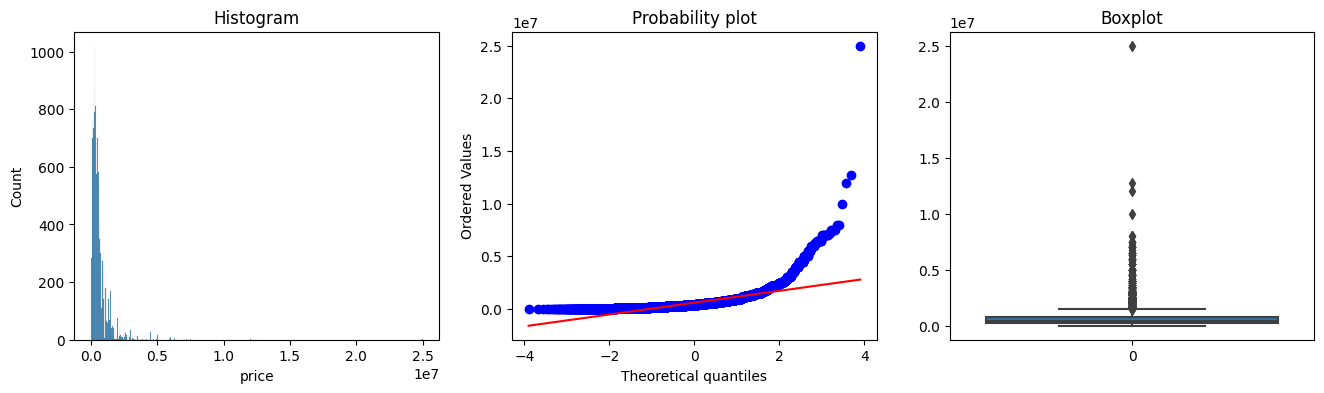

In [11]:
diagnostic_plots(df1, 'price')

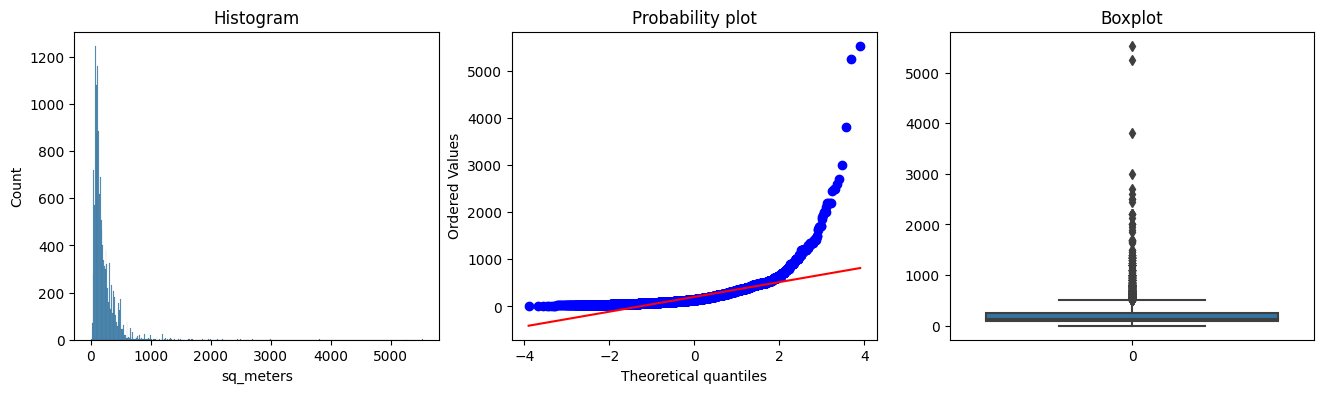

In [12]:
# We will not include the unrealistically high value of 140,000 sq_meters, so we can have a more informative 
# realization: 

diagnostic_plots(df1[df1['sq_meters']<140000], 'sq_meters')

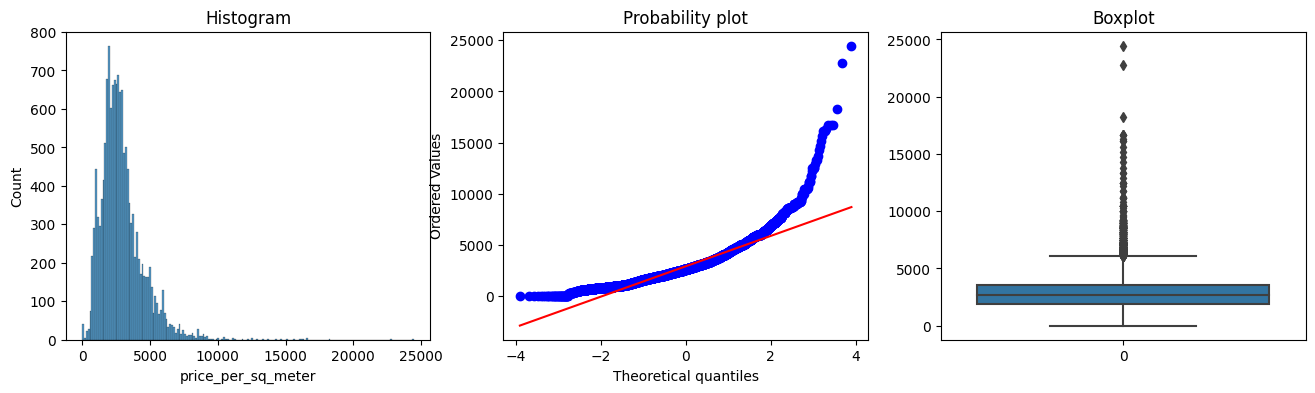

In [13]:
# We will not include the two extreme values where price
diagnostic_plots(df1[df1['price_per_sq_meter']<200000], 'price_per_sq_meter')

In [14]:
def find_boundaries_skewed(df, feature, fold):
    '''
    Finding the lower and upper limits when the dataset is skewed, using the Interquantile Range.
    '''
    
    q25 = df[feature].quantile(0.25)
    q75 = df[feature].quantile(0.75)
    # Interquantile Range:
    IQR = q75 - q25
    
    # Finding the boundaries:
    lower_boundary = q25 - fold * IQR
    upper_boundary = q75 + fold * IQR
    
    return(lower_boundary, upper_boundary)


def find_boundaries_normal(df, feature, fold):
    '''
    Finding the lower and upper limits when the dataset is symmetical, using the 3sigma rule.
    '''
    
    mean = df[feature].mean()
    sigma = df[feature].std()
    
    lower_boundary = mean - fold * sigma
    upper_boundary = mean + fold * sigma
    
    return(lower_boundary, upper_boundary)

#### Square meters

In [15]:
lowlimit, highlimit = find_boundaries_skewed(df1, 'sq_meters', 3)
print(lowlimit, highlimit)

-405.0 750.0


In [16]:
lowlimit, highlimit = find_boundaries_normal(df1, 'sq_meters', 3)
print(round(lowlimit), round(highlimit))

-3318 3745


In [17]:
df1[df1['sq_meters']>3000]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
3066,38894841,10961.000,northern sub,other residential,2002,5530,5500000,994.575
5579,42420101,11240.000,south beach,other residential,2012,5250,12000000,2285.714
12080,40443485,9309.000,northern sub,building,2155,3800,7000000,1842.105
12758,43180452,19079.000,beesy neighborhood,apartment,1961,140000,165000,1.179


In [18]:
df1[df1['sq_meters']<15]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
9765,42091580,6427.000,beesy neighborhood,studio,2155,14,40000,2857.143
10700,35421691,5976.000,south beach,maisonette,2008,1,620000,620000.000
12536,42320237,7355.000,beesy neighborhood,studio,1980,12,21000,1750.000
12721,43078274,NaN,beesy neighborhood,houseboat,0,10,2500000,250000.000


In [19]:
unrealistic_sq_meters = np.where(df1['sq_meters'] > 100000, True,
                        np.where(df1['sq_meters'] < 12, True, False))

#### Price

In [20]:
df1[df1['price']>10000000]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
1223,42617908,19215.000,south beach,other residential,2012,1890,12750000,6746.032
5579,42420101,11240.000,south beach,other residential,2012,5250,12000000,2285.714
7425,42344599,12423.000,northern sub,detached,1920,1100,25000000,22727.273


In [21]:
df1[df1['price']<8000]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
551,43447318,18491.000,northern sub,detached,0,270,450,1.667
2162,43208250,13328.000,south beach,apartment,2019,277,1,0.004
2220,43028226,13328.000,south beach,apartment,2019,229,1,0.004
2221,43028230,13328.000,south beach,apartment,2019,231,1,0.004
2222,43028231,13328.000,south beach,apartment,2019,150,1,0.007
2223,43028235,13328.000,south beach,apartment,2019,148,1,0.007
2224,43028243,13328.000,south beach,apartment,2019,148,1,0.007
2226,43028247,13328.000,south beach,apartment,2019,135,1,0.007
2227,43028252,13328.000,south beach,apartment,2019,136,1,0.007
2228,43028253,13328.000,south beach,maisonette,2019,363,1,0.003


In [22]:
unrealistic_price = np.where(df1['price'] > 30000000, True,
                        np.where(df1['price'] < 8000, True, False))

#### Price per square meter

In [23]:
df1[df1['price_per_sq_meter']>20000]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
7425,42344599,12423.000,northern sub,detached,1920,1100,25000000,22727.273
10700,35421691,5976.000,south beach,maisonette,2008,1,620000,620000.000
11779,41449891,9619.000,northern sub,detached,1910,327,8000000,24464.832
12721,43078274,NaN,beesy neighborhood,houseboat,0,10,2500000,250000.000


In [24]:
df1[df1['price_per_sq_meter']<4].head()

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
551,43447318,18491.000,northern sub,detached,0,270,450,1.667
2162,43208250,13328.000,south beach,apartment,2019,277,1,0.004
2220,43028226,13328.000,south beach,apartment,2019,229,1,0.004
2221,43028230,13328.000,south beach,apartment,2019,231,1,0.004
2222,43028231,13328.000,south beach,apartment,2019,150,1,0.007


In [25]:
unrealistic_price_per_sq_meters = np.where(df1['price_per_sq_meter'] >= 250000, True,
                                  np.where(df1['price_per_sq_meter'] < 4, True, False))

### Apply the first trimming/deletion of unrealistic values

In [26]:
# We trim the dataframe from all the unrealistic values as defined above: 

df1_trimmed = df1.loc[~(unrealistic_price + unrealistic_price + unrealistic_price_per_sq_meters)].copy()

print(f"Rows deleted: {df1.shape[0]-df1_trimmed.shape[0]}")

Rows deleted: 42


#### A summary of some Unrealistic values

Here are some of the unrealistic findings:

- houses with a price equal to 0 or 1
- a maisonette of 1 sq_meter for a price of 620,000
- a houseboat of 10 sq_meters for a price of 2,500,000
- a deteached house of 1100 sq_meters for a price of 25,000,000
- an apartment of 140,000 sq_meters for a price of 165,000

In [27]:
ids_unrealistic = [38542490, 3856970, 43078274, 43180452]
df1[np.isin(df1['id'], ids_unrealistic)]

,id,agent_id,geography_name,subtype,year_of_construction,sq_meters,price,price_per_sq_meter
5169,38542490,8123.000,northern sub,building,1980,307,0,0.000
12721,43078274,NaN,beesy neighborhood,houseboat,0,10,2500000,250000.000
12758,43180452,19079.000,beesy neighborhood,apartment,1961,140000,165000,1.179


For the purpose of Question 01, we only removed the Outliers that we considered to be Unrealistic values, and  probably were mistyped into the dataset. There are still Outliers (as we see from the following plots), which are reasonable (in a sense) and very probably refer to real houses, and thus we choose to keep them for the demonstration reasons of Question 01. 

It may be the case though that for Question 03 we further treat the existing outliers, depending on the model to be chosen, in order to comply with its assumptions and to improve its predictive performance. 

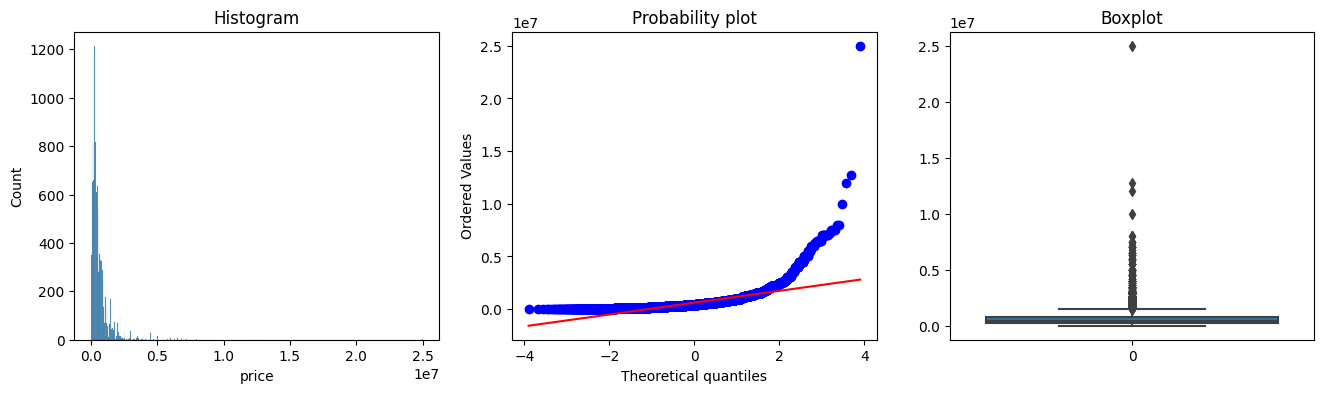

In [28]:
diagnostic_plots(df1_trimmed, 'price')

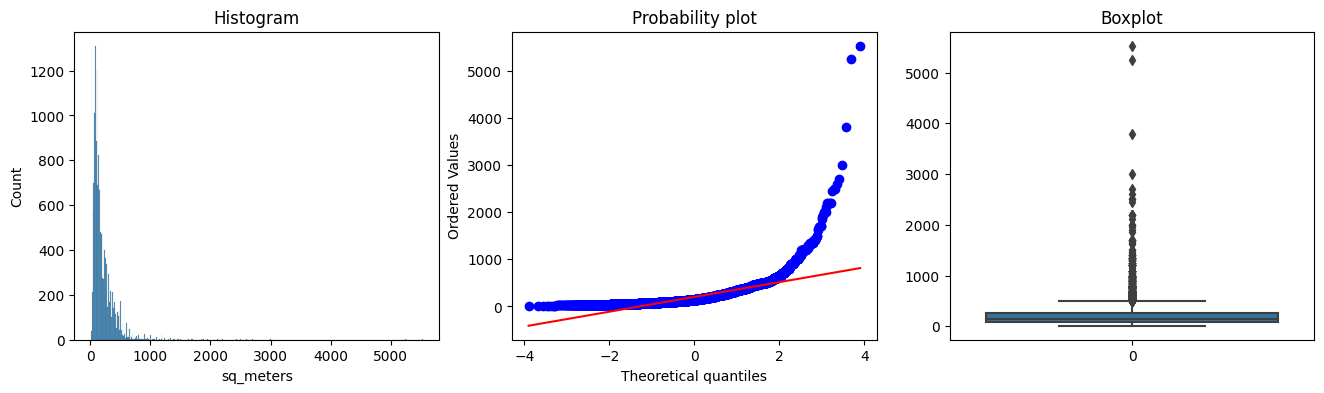

In [29]:
diagnostic_plots(df1_trimmed, 'sq_meters')

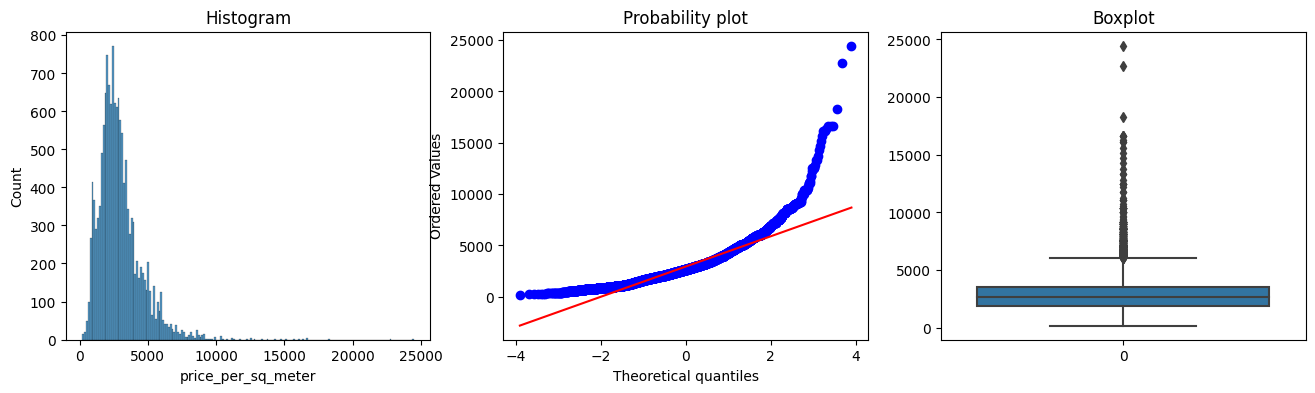

In [30]:
diagnostic_plots(df1_trimmed, 'price_per_sq_meter')

### Answer for Question 01

In [31]:
# Summary statistics for the feature 'price_per_square_meter':

df1_trimmed.groupby(['geography_name', 'subtype']).price_per_sq_meter.\
                                                agg(['min', 'max', 'mean', 'median', 'std']).round()

min       max     mean   median   
geography_name      subtype                                                  
beesy neighborhood  apartment          222.000  3958.000 1282.000 1133.000  \
                    apartment complex  600.000  1571.000 1154.000 1184.000   
                    building           556.000  3942.000 1095.000  995.000   
                    detached           429.000  5405.000 1446.000 1255.000   
                    maisonette         806.000  4688.000 1858.000 1667.000   
                    other residential  196.000  4302.000 1313.000 1206.000   
                    studio             258.000  3200.000 1090.000 1000.000   
gentrification area apartment          625.000  7018.000 2619.000 2500.000   
                    apartment complex 3202.000  3247.000 3225.000 3225.000   
                    building          1261.000  9333.000 2957.000 2412.000   
                    detached           857.000  8800.000 2956.000 2713.000   
                    loft              2436.000  2436.000 2436.000 2436.000   
                    maisonette        1864.000  3929.000 2621.000 2286.000   
                    other residential 1846.000  3400.000 2377.000 2314.000   
                    studio             833.000  4167.000 2263.000 2250.000   
northern sub        apartment          353.000  9960.000 2811.000 2500.000   
                    apartment complex 1263.000  6250.000 3348.000 3115.000   
                    building           317.000  8021.000 2689.000 2166.000   
                    detached           250.000 24465.000 3002.000 2500.000   
                    maisonette         800.000  8368.000 2548.000 2257.000   
                    other residential  995.000 11765.000 3584.000 2750.000   
                    studio            1622.000  2000.000 1905.000 2000.000   
                    villa             1000.000 14706.000 3357.000 2518.000   
south beach         apartment          755.000 18261.000 3508.000 3200.000   
                    apartment complex 1176.000  5017.000 2430.000 2195.000   
                    building           818.000  7500.000 2664.000 2167.000   
                    bungalow          2167.000  2267.000 2217.000 2217.000   
                    detached           967.000 16667.000 3406.000 2857.000   
                    loft              2326.000  6211.000 4113.000 4457.000   
                    maisonette         850.000 10417.000 4166.000 3929.000   
                    other residential 1111.000  6746.000 3411.000 3086.000   
                    studio             625.000  4545.000 2511.000 2353.000   
                    villa             1765.000  6667.000 3499.000 3077.000   

                                           std  
geography_name      subtype                     
beesy neighborhood  apartment          508.000  
                    apartment complex  404.000  
                    building           430.000  
                    detached           727.000  
                    maisonette         795.000  
                    other residential  817.000  
                    studio             610.000  
gentrification area apartment          807.000  
                    apartment complex   31.000  
                    building          1749.000  
                    detached          1419.000  
                    loft                   NaN  
                    maisonette         654.000  
                    other residential  536.000  
                    studio             808.000  
northern sub        apartment         1219.000  
                    apartment complex 1588.000  
                    building          1648.000  
                    detached          1972.000  
                    maisonette         997.000  
                    other residential 2541.000  
                    studio             164.000  
                    villa             2518.000  
south beach         apartment         1314.000  
                    apartment complex 

## Question 02 <a class="anchor" id="4"></a>

<img src="pics/question_2.png" style="width: 700px;"/>

Having done some basic pre-processing on the dataset (removing duplicates and trimming out houses with strange values on the 'price', 'sq_meter' and 'price_per_sq_meter') which we named `df1_trimmed`, we continue with that dataset but considering different features, those that are related to answering Question 02. The dataset for this question will be the `df2`.

For the competitiveness score we will not need any information regarding the houses, but only those related with the agents and ranking of the houses, as well as the geographic area.

In [32]:
# Take the indexes of the rows of df1_trimmed:
idxs = list(df1_trimmed.index)
cols2 = ['geography_name', 'id', 'agent_id', 'ad_type', 'ranking_score']
df2 = data.loc[idxs, cols2].copy()
df2.head()

,geography_name,id,agent_id,ad_type,ranking_score
0,northern sub,42911697,14680.000,simple,47.000
1,northern sub,43018583,15502.000,simple,134.700
2,northern sub,39670968,9807.000,simple,71.000
3,northern sub,39740833,14682.000,simple,122.000
4,northern sub,39742998,14682.000,simple,126.700


There are missing values on the `agent_id`. Since we are interested in the number of agents that are involved in each geographical area (we will count them per geographical area), it is completely fine to fill in the missing values with a randomly generated number.

In [33]:
df2.isnull().sum()

geography_name     0
id                 0
agent_id          95
ad_type            0
ranking_score      0
dtype: int64

In [34]:
# Fill in missing values with a randomly generated number that is greater than the max 'agent_id':

df2['agent_id'].fillna(value=random.randint(df2.agent_id.max()+1, df2.agent_id.max()+ 100000), inplace=True) 

We will use the features `id` and `agent_id` to create a score (which we refer to as `score1`) for each geographical area. This score will be computed from:
- the number of houses (total count of 'id'), 
- the number of agents (total count of unique 'agent_id')

The score will be the sum of the proportions of these two features. 

In [35]:
df_houses_agents = df2.groupby(by='geography_name').nunique().loc[:,['id', 'agent_id']]
df_houses_agents

,id,agent_id
geography_name,,
beesy neighborhood,2073,304
gentrification area,799,213
northern sub,4956,284
south beach,6634,331


In [36]:
# Each row on the initial dataset refers to a unique house, so this ratio is taken by deviding the total number 
# of rows:
house_ratio = df2.groupby(by='geography_name').nunique().loc[:,['id']]/df2.shape[0]

# The denominator of this proportion will be the unique number of agents on each geographical area, which is the 
# sum of the column 'agent_id' of the aforementioned table:
agent_ratio = df2.groupby(by='geography_name').nunique().loc[:,['agent_id']]/df_houses_agents.sum(axis=0).agent_id

# Compute the score as the sum of the ratios:
score_df = pd.merge(house_ratio, agent_ratio, on='geography_name')
score_df['score1'] = score_df['id'] + score_df['agent_id']
score_df

,id,agent_id,score1
geography_name,,,
beesy neighborhood,0.143,0.269,0.412
gentrification area,0.055,0.188,0.243
northern sub,0.343,0.251,0.594
south beach,0.459,0.292,0.751


How to interpret `score1`: 

The higher the score the more the houses and agents on a specific geographic area. Consequently a high `score1` would mean that the area is more competitive. 

We will also try and incorporate the `ad_type` and the `ranking_score` into a score. As a first step, on the initial dataset, for each house we will compute a `composite_ranking_score` which will the product of `ranking_score` with `ad_type_ordinal` (

In [37]:
# Create tje ad_type_ordinal:
mapping_dict = {'simple': 1, 'up': 2, 'premium': 3, 'star': 4}
df2['ad_type_ordinal'] = df2['ad_type'].replace(mapping_dict)

# Compute the composite ranking score: 
df2['composite_ranking_score'] = df2['ad_type_ordinal']*df2['ranking_score']

In [38]:
df2.head()

,geography_name,id,agent_id,ad_type,ranking_score,ad_type_ordinal,composite_ranking_score
0,northern sub,42911697,14680.000,simple,47.000,1,47.000
1,northern sub,43018583,15502.000,simple,134.700,1,134.700
2,northern sub,39670968,9807.000,simple,71.000,1,71.000
3,northern sub,39740833,14682.000,simple,122.000,1,122.000
4,northern sub,39742998,14682.000,simple,126.700,1,126.700


In [39]:
# We take the average composite_ranking_score for each geographical area: 

composite_df = pd.DataFrame(df2.groupby(by='geography_name')['composite_ranking_score'].mean())
composite_df

,composite_ranking_score
geography_name,
beesy neighborhood,122.801
gentrification area,140.144
northern sub,140.016
south beach,129.409


In [40]:
def min_max_scaler(x):
    '''
    Scales the data between 0 and 1.
    '''
    
    x_np = np.array(x)
    scaled_x = (x - np.min(x))/(np.max(x) - np.min(x))
    
    return(scaled_x)

score2 = list(composite_df.composite_ranking_score)
score2_normalized = min_max_scaler(score2)

In [41]:
score_df['score2'] = score2_normalized


In [42]:
score_df['score'] = score_df['score1'] + score_df['score2']
score_df.drop(['id', 'agent_id'], axis=1, inplace=True)
score_df

,score1,score2,score
geography_name,,,
beesy neighborhood,0.412,0.000,0.412
gentrification area,0.243,1.000,1.243
northern sub,0.594,0.993,1.586
south beach,0.751,0.381,1.132


In [43]:
# Normalize this final score between zero and one, and multiply by 10:
score_df['score-last'] = 10*min_max_scaler(score_df['score'])
score_df

,score1,score2,score,score-last
geography_name,,,,
beesy neighborhood,0.412,0.000,0.412,0.000
gentrification area,0.243,1.000,1.243,7.081
northern sub,0.594,0.993,1.586,10.000
south beach,0.751,0.381,1.132,6.133


### What to do if I had more time

Ultimately, the above features could be used to create a Machine Learning model that will compute a score.

##  Question 03 <a class="anchor" id="5"></a>

<img src="pics/question_3.png" style="width: 700px;"/>

The answer that follows, which is ML engineering and modelling, is written linearly in the form of a story, with comments and single steps explaining the reasoning. If the model had a purpose to be put into production further code refactoring and automation would have be done.

-Giorgos-

In [44]:
# We use the indeces of the cleaned dataset that occured after Question 01, to create the DataFrame that
# we will further engineer and use for Question 03:

idxs = list(df1_trimmed.index)

df3 = data.loc[idxs].copy()

### Feature exploration <a class="anchor" id="feature_exploration"></a>

In this section we explore the dataset and decide the actions to be taken regarding each of the features. The feature engineering and cleaning will be done on the next section.

#### Features with many missing values

The features 
- `accessible_for_disabled`, 
- `energy_class` and 
- `equipped` 

have a high percentage of missing values and therefore will (later) be discarded.

In [45]:
x=['accessible_for_disabled', 'energy_class', 'equipped']

100*df3[x].isna().sum()/df3.shape[0]

accessible_for_disabled    96.280
energy_class               86.281
equipped                  100.000
dtype: float64

#### The Boolean features (or Utilities features)

We consider seperately the Boolean features, i.e. those taking True/False values, which we also call *Utility features* since most of them (but not all) refer to whether the houses include specific utilites or not (like a `pool`, a `garage`, etc). We call the remaining *rest features*. 

In [46]:
# Find the Boolean features (Those that take True/False Values): 
boolean_features = [col for col in df3.columns if set(df3[col].unique())==set([True,False,np.nan])]
df3_utilities = df3[boolean_features].copy()

# The rest of the features: 
rest_features = list(set(df3.columns).difference(set(boolean_features)))
df3_rest = df3[rest_features].copy()

# Validation check:
len(rest_features) + len(boolean_features) == df3.shape[1]

True

In [47]:
missing_bool = pd.DataFrame(100*df3_utilities.isna().sum()/df3.shape[0])
print(f"Min missing value on features: {round(missing_bool.min()[0], 1)}%")
print(f"Max missing value on features: {round(missing_bool.max()[0], 1)}%")

Min missing value on features: 10.7%
Max missing value on features: 96.3%


There are at least two explanations on why there are missing values on the Boolean/Utilities features: 

1. the utilities are not present in the house, or do not apply to specific houses, so a missing value could be considered as a value equal to False
    
2. the agent that performed the data entry did not understand or was lazy to complete all the fields.


A fast way would be to consider that it is the 1st case and to impute all missing values with False. 

Another way would be to assume that some of these Boolean features are correlated with other features, and do a more careful data imputation (for example a house's `subtype` could be handy since it may give as hints on the utilities.  It is more possible that a `pool` (for example) will be present on a `maisonette` or a `villa` house rather than an `apartment` or `studio`.  We could generate a `pivot_table` (or a relative frequency table) with the utilities as rows, the different `subtype`s as columns and the entries would be the relative frequency of a utility being present on a specific type of house. If the value was above 50% we would impute True/1 otherwise False/0. 

#### Floor

The variable `floor` has missing values. A reasonable explanation is that these houses are not on a floor, but on the ground floor. We will thus impute it with 'ground'.

Further on, we see that there are few values for the great floor values (only one house on the 10th or 11th or 20th floor). To *decrease the cardinality* we create a new feature that will hold all the floors above or equal to 6.

In [48]:
df3.floor.value_counts(dropna=False)

floor
ground-floor     4904
1                2927
2                1979
3                1761
4                1117
NaN               727
5                 413
basement          178
mezzanine         167
semi-basement     141
6                 114
7                  28
8                   3
20                  1
11                  1
10                  1
Name: count, dtype: int64

#### Years since construction

Instead of keeping the `year_of_construction`, we will subtract it from the current year, 2023, in order to create the feature `years_since_construction`. 

We are also told that a value of `2155` means that the house is still under construction. We will thus replace it with the current year, 2023, so that after the subtraction the value of `years_since_construction` for all the houses that are under construction will be `0`.

In [49]:
df_plot = df3.copy()

df_plot['year_of_construction'].replace(to_replace=2155, value=2023, inplace=True)
df_plot['years_since_construction'] = 2023 - df_plot['year_of_construction']

As we see from the boxplots below, there are some **extreme values** in the newly created feature `years_since_construction`. These are: 
- Two values around 1000. These big ages could be legitimate for very rare old houses, but because it distorts the distribution of the feature, we will replace them with the *maximum value among the normal values* (i.e. excluding the extreme values mentioned here), in order to keep their (assumed) character of an old house.
- Some values of 2023, which occured for the houses which had the initial feature `year_of construction` equal to zero. We don't the explanation of these values so we will replace them with the *median* value.

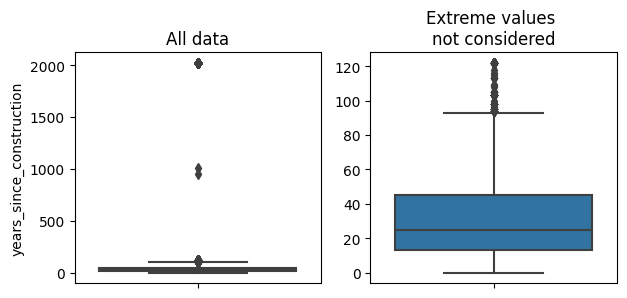

In [50]:
fig, ax = plt.subplots(1,2,figsize=(7,3))

sns.boxplot(df_plot, y='years_since_construction', ax=ax[0])
sns.boxplot(df_plot[df_plot['years_since_construction']<750], y='years_since_construction', ax=ax[1])
ax[1].set_ylabel('')
ax[0].set_title('All data')
ax[1].set_title('Extreme values \nnot considered')
plt.show()

#### Years since renovation

We will use the feature `renovation_year` to create the feature `years_since_renovation`. 

We will assume that missing values on this feature mean that the house was never renovated (we could also use the `renovated` feature for cross-checking that), and thus we will fill them in the corresponding value of `years_since_construction`. If the house was never renovated, then the last time that (re)building was made was when it was constructed. 

In [51]:
# Create the new feature:
df_plot['years_since_renovation'] = 2023 - df_plot['renovation_year']

In [52]:
# Many missing values
df_plot.isna().sum().years_since_renovation

12572

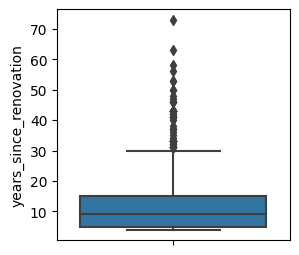

In [53]:
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(df_plot, y='years_since_renovation')
plt.show()

## Feature engineering <a class="anchor" id="feature_engineering"></a>

In [54]:
def drop_unecessary_features(df):
    '''
    - The feature 'ad_type' and 'ranking_score' are not house characteristics and are relative to how the houses
      are displayed on the website,
    - The 'id' and 'agent_id' are ids and thus not useful for predicting the target variable.
    - The 'accessible_for_disabled', 'energy_class', and 'equipped' have lots of missing values (96%, 86% and 100% 
      respectively) and thus are not useful at all.
    '''
    
    cols_delete = ['id', 'agent_id', 'ad_type', 'ranking_score', 'accessible_for_disabled', 
                   'energy_class', 'equipped']
    df.drop(columns=cols_delete, inplace=True)
    
    return(df)
  
    
def engineer_boolean_values(df):
    '''
    Regarding the Boolean features:
        - As we have seen, the Boolean features (or utility features) all have missing values between
    '''
    
    # The Boolean features (Those that take True/False Values): 
    boolean_features = [col for col in df.columns if set(df[col].unique())==set([True,False,np.nan])]
    
    # Fill in Boolean values with False:
    df_utilities = df[boolean_features]
    df_utilities = df_utilities.fillna(value=False)
    df_utilities = df_utilities.replace({True: 1, False: 0})
    
    df[boolean_features] = df_utilities

    return(df)

    
def engineer_floor(df):
    '''
    Regarding the feature 'floor':
        - We assume that missing values are explained as to the house not being on a floor, and thus it is on the
          ground floor. We impute it with 'ground'
        - To decrease the cardinality we create a new feature that will hold all the floors above or equal to 6
        - Apply One-hot Encoding.
    '''
    
    # Change for elegance (as the word 'floor' is later added as prefix):
    df['floor'] = df['floor'].replace(to_replace='ground-floor', value='ground')
    
    # Fill in missing values with 'ground':
    df['floor'].fillna(value='ground', inplace=True)
    
    # We will decrease the cardinality of the feature 'floor' by creating a new value that will 
    # hold all the floors above or equal to floor 6: 
    df['floor'] = df['floor'].replace(to_replace=['6', '7', '8', '10','11','20'], value='6_or_above')
    
    return(df)
   
    
def engineer_years_since_renovation(df):
    '''
    Create new feature 'years_since_renovation' and fill in missing values.
    '''
    
    # Create feature 'years_since_renovation':
    df['years_since_renovation'] = 2023 - df['renovation_year']
    df.drop(columns='renovation_year', inplace=True)
    
    # Fill in the missing values with corresponding value of 'years_since_construction':
    df['years_since_renovation'].fillna(df['years_since_construction'], inplace=True)    
    
    return(df)

    
def engineer_years_since_construction(df):
    '''
    Create the new feature 'years_since_construction' and treat extreme values.
    '''
 
    # We will replace 2155 with 2023, the year we have now, since it is under construction: 
    df['year_of_construction'].replace(to_replace=2155, value=2023)
    
    # Create feature 'years_since_construction':
    df['years_since_construction'] = 2023 - df['year_of_construction']
    
    # Replace extreme values:
    df['years_since_construction'].replace(to_replace=2023, 
                                        value=df['years_since_construction'].median(), inplace=True)
    df['years_since_construction'].replace(to_replace=[953, 1004], 
                                        value=df[df['years_since_construction']<900].\
                                        years_since_construction.max(), inplace=True)
    
    # Drop the 3 features related to year of construction, since in the newly created feature the
    # information given by 'unfinished' and 'new_development' is implicitly included.
    df.drop(columns=['year_of_construction', 'unfinished', 'new_development'], inplace=True)
    
    return(df)

    
def engineer_subtype(df):
    '''
    Put an underscore on the name.
    '''
    
    # Replace <space> with <underscore>:
    df['subtype'] = df['subtype'].str.replace(' ', '_')
    
    return(df)
    
    
def engineer_geography_name(df):
    '''
    Regarding the feature 'geography_name': 
        - We replace the <space> with <underscore>
        - We apply One-hot Encoding.
    '''
    
    # Replace <space> with <underscore>:
    df['geography_name'] = df['geography_name'].str.replace(' ', '_')
    
    return(df)


def apply_onehot_encoding(df):
    '''
    For all categorical features it applies One-hot encoding.
    '''

    # Apply to 'floor':
    df = pd.concat([df, pd.get_dummies(df.floor, prefix='floor')], axis=1)
    df.drop(columns='floor', inplace=True)
    
    # Apply to 'subtype':
    df = pd.concat([df, pd.get_dummies(df.subtype, prefix='subtype')], axis=1)
    df.drop(columns='subtype', inplace=True)
    
    # Apply to 'geography_name': 
    df = pd.concat([df, pd.get_dummies(df.geography_name, prefix='area')], axis=1)
    df.drop(columns='geography_name', inplace=True)
    
    return(df)

    
def apply_feature_engineering(df):
    '''
    Call all the above functions to apply the necessary feature engineering. 
    '''
    
    df = drop_unecessary_features(df)
    df = engineer_boolean_values(df)
    df = engineer_floor(df)
    df = engineer_years_since_construction(df)
    df = engineer_years_since_renovation(df)
    df = engineer_subtype(df)
    df = engineer_geography_name(df)
    df = apply_onehot_encoding(df)
    
    return(df)

In [55]:
idxs = list(df1_trimmed.index)
df3 = data.loc[idxs].copy()

# The dataset after the feature engineering:
df3_final = apply_feature_engineering(df3)

#### Pearson's Correlation Coefficient

In [56]:
# Top 10 features correlated with the target variable 'price', in descending order.
corr_df = df3_final.corr().price
corr_df.sort_values(ascending=False).drop('price', axis=0).head(10)

sq_meters          0.727
no_of_bathrooms    0.424
rooms              0.337
pool               0.327
no_of_wc           0.327
subtype_detached   0.320
floor_ground       0.310
internal_stairs    0.281
garden             0.259
playroom           0.248
Name: price, dtype: float64

In [57]:
#boolean_features = [col for col in df3_final if set(df3_final[col])=={0,1}]
#sns.heatmap(df3_final[boolean_features].corr())

In [58]:
df3_final.shape

(14462, 68)

#### Train-test split

We split the dataset into a *train set* with 70% of the data for training the model, and a *test set* with the rest 30% for evaluating the model. In this way we can see how good our model(s) generalize on previously unseen data. 

In [59]:
X, y = df3_final.drop('price', axis=1), df3_final.loc[:,'price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

#### Scaling features

We will normalize all the numerical features, not the Boolean though since they don't need Normalization. This will help to improve the performance of the linear regression algorithm and ensure that the coefficients are meaningful.

Scaling the data is particularly important when using distance-based ML algorithms, such as Linear Regression for example. Tree-based models are not much affected by unscaled data. 


In [60]:
non_boolean = [col for col in X.columns if set(X[col])!={0,1}]
boolean = list(set(X.columns).difference(set(non_boolean)))

In [61]:
scaler = StandardScaler()

# StandardScaler returns numpy arrays:
X_train_scaled_np = scaler.fit_transform(X_train[non_boolean])
X_test_scaled_np = scaler.transform(X_test[non_boolean])

# Convert them again into DataFrames:
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=non_boolean)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=non_boolean)

In [62]:
# Add the Boolean and the Non-Boolean features altogether: 
X_train_scaled = pd.concat([X_train_scaled.reset_index(drop=True), 
                              X_train[boolean].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test_scaled.reset_index(drop=True), 
                             X_test[boolean].reset_index(drop=True)], axis=1)

We validate that now all (non-boolean) features are centered around zero with a standard deviation of 1. 

In [63]:
X_train_scaled[non_boolean].describe().loc[['mean', 'std']]

,sq_meters,rooms,no_of_bathrooms,no_of_wc,living_rooms,kitchens,balcony_area,years_since_construction,years_since_renovation
mean,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


#### Choosing Evaluation Metric

In order to measure how well the trained model is performing, the *Root Mean Squared Error (RMSE)* metric has been chosen. 

The advantage of using RMSE over MSE (*Mean Squared Error*) is that it is more interpretable and easier to understand as it is in the same units as the target variable. This means that RMSE can give us a better idea of the magnitude of the error in our predictions.

#### Establishing a baseline performance

To provide a starting point for the evaluation of the performance of the models, we will *establish a baseline of performance*, which we will use as a benchmark to evaluate the performance of more complex models. This baseline will be the performance of a simple model that always predicts the *mean* value computed on the train set. 

In [64]:
# The predictions will be the average 'price' computed on the train set:
pred_baseline = y_train.mean() 
mse = mean_squared_error(np.array(y_test), np.full((y_test.shape[0]),pred_baseline))
r2 = r2_score(np.array(y_test), np.full((y_test.shape[0]),pred_baseline))
rmse_baseline = int(np.sqrt(mse))

print(f"The baseline performance is: \tRMSE = {rmse_baseline}")
print(f"R2-score of baseline: \t\tR2={round(r2,5)}")

The baseline performance is: 	RMSE = 725179
R2-score of baseline: 		R2=-0.00042


### Train models <a class="anchor" id="train_models"></a>

This is a Supervised ML problem, and specifically a **Regression problem**, since what we are are predicting is a numerical variable, *price*. 

### Extreme Gradient Boosting (XGBoost)

#### Hyper-parameter tuning

In [65]:
gbm_param_grid = {'learning_rate': [0.01, 0.1, 0.5, 0.9],
                  'n_estimators': [100, 200],
                  'subsample': [0.3, 0.4, 0.5, 0.9, 1]}

xgb = XGBRegressor()

grid_mse = GridSearchCV(estimator=xgb, 
                        param_grid=gbm_param_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X_train_scaled, y_train)

print(f"\nBest parameters found: {grid_mse.best_params_}")
print(f"\nLowest RMSE found:  {int(np.sqrt(np.abs(grid_mse.best_score_)))}")

Fitting 4 folds for each of 40 candidates, totalling 160 fits

Best parameters found: {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}

Lowest RMSE found:  429660


#### Making predictions on the test set

In [66]:
xgb = XGBRegressor(learning_rate=0.1, n_estimators=200, subsample=0.9)
xgb.fit(X_train_scaled, y_train)

y_pred_test = xgb.predict(X_test_scaled)
y_pred_train = xgb.predict(X_train_scaled)

mse_train = mean_squared_error(y_pred_train, y_train)
rmse_train = np.sqrt(mse_train)
mse_test = mean_squared_error(y_pred_test, y_test)
mae_test = mean_absolute_error(y_pred_test, y_test)
rmse_test = np.sqrt(mse_test)
r2 = r2_score(y_pred_test, y_test)

print(f"RMSE on train set: {int(rmse_train)}")
print(f"RMSE on test set:  {int(rmse_test)}")

print(f"\nRMSE baseline:     {rmse_baseline}")

print(f"\nR2-score on test set: {round(r2,3)}")


RMSE on train set: 152783
RMSE on test set:  440662

RMSE baseline:     725179

R2-score on test set: 0.608


We see that the accuracy of XGBoost on the test set is better than the baseline. On the other hand the performance of the model on the test set is significantly worse than the performance on the train set. This is a sign of *high-bias (overfitting)*. 

### Importance of Features

A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.

The following graph provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

The 10 most important features that an agent should input to get an accurate forecast are, in descending importance, are: 

1. Number of Square meters
2. Age of building (# years since it was constructed)
3. Number of rooms
4. Number of years since it was renovated
5. Number of bathrooms
6. Number of wc
7. Whether it is of 'detached' type
8. Number of kitchens
9. Number of living rooms
10. Whether it is on 'South beach' area 

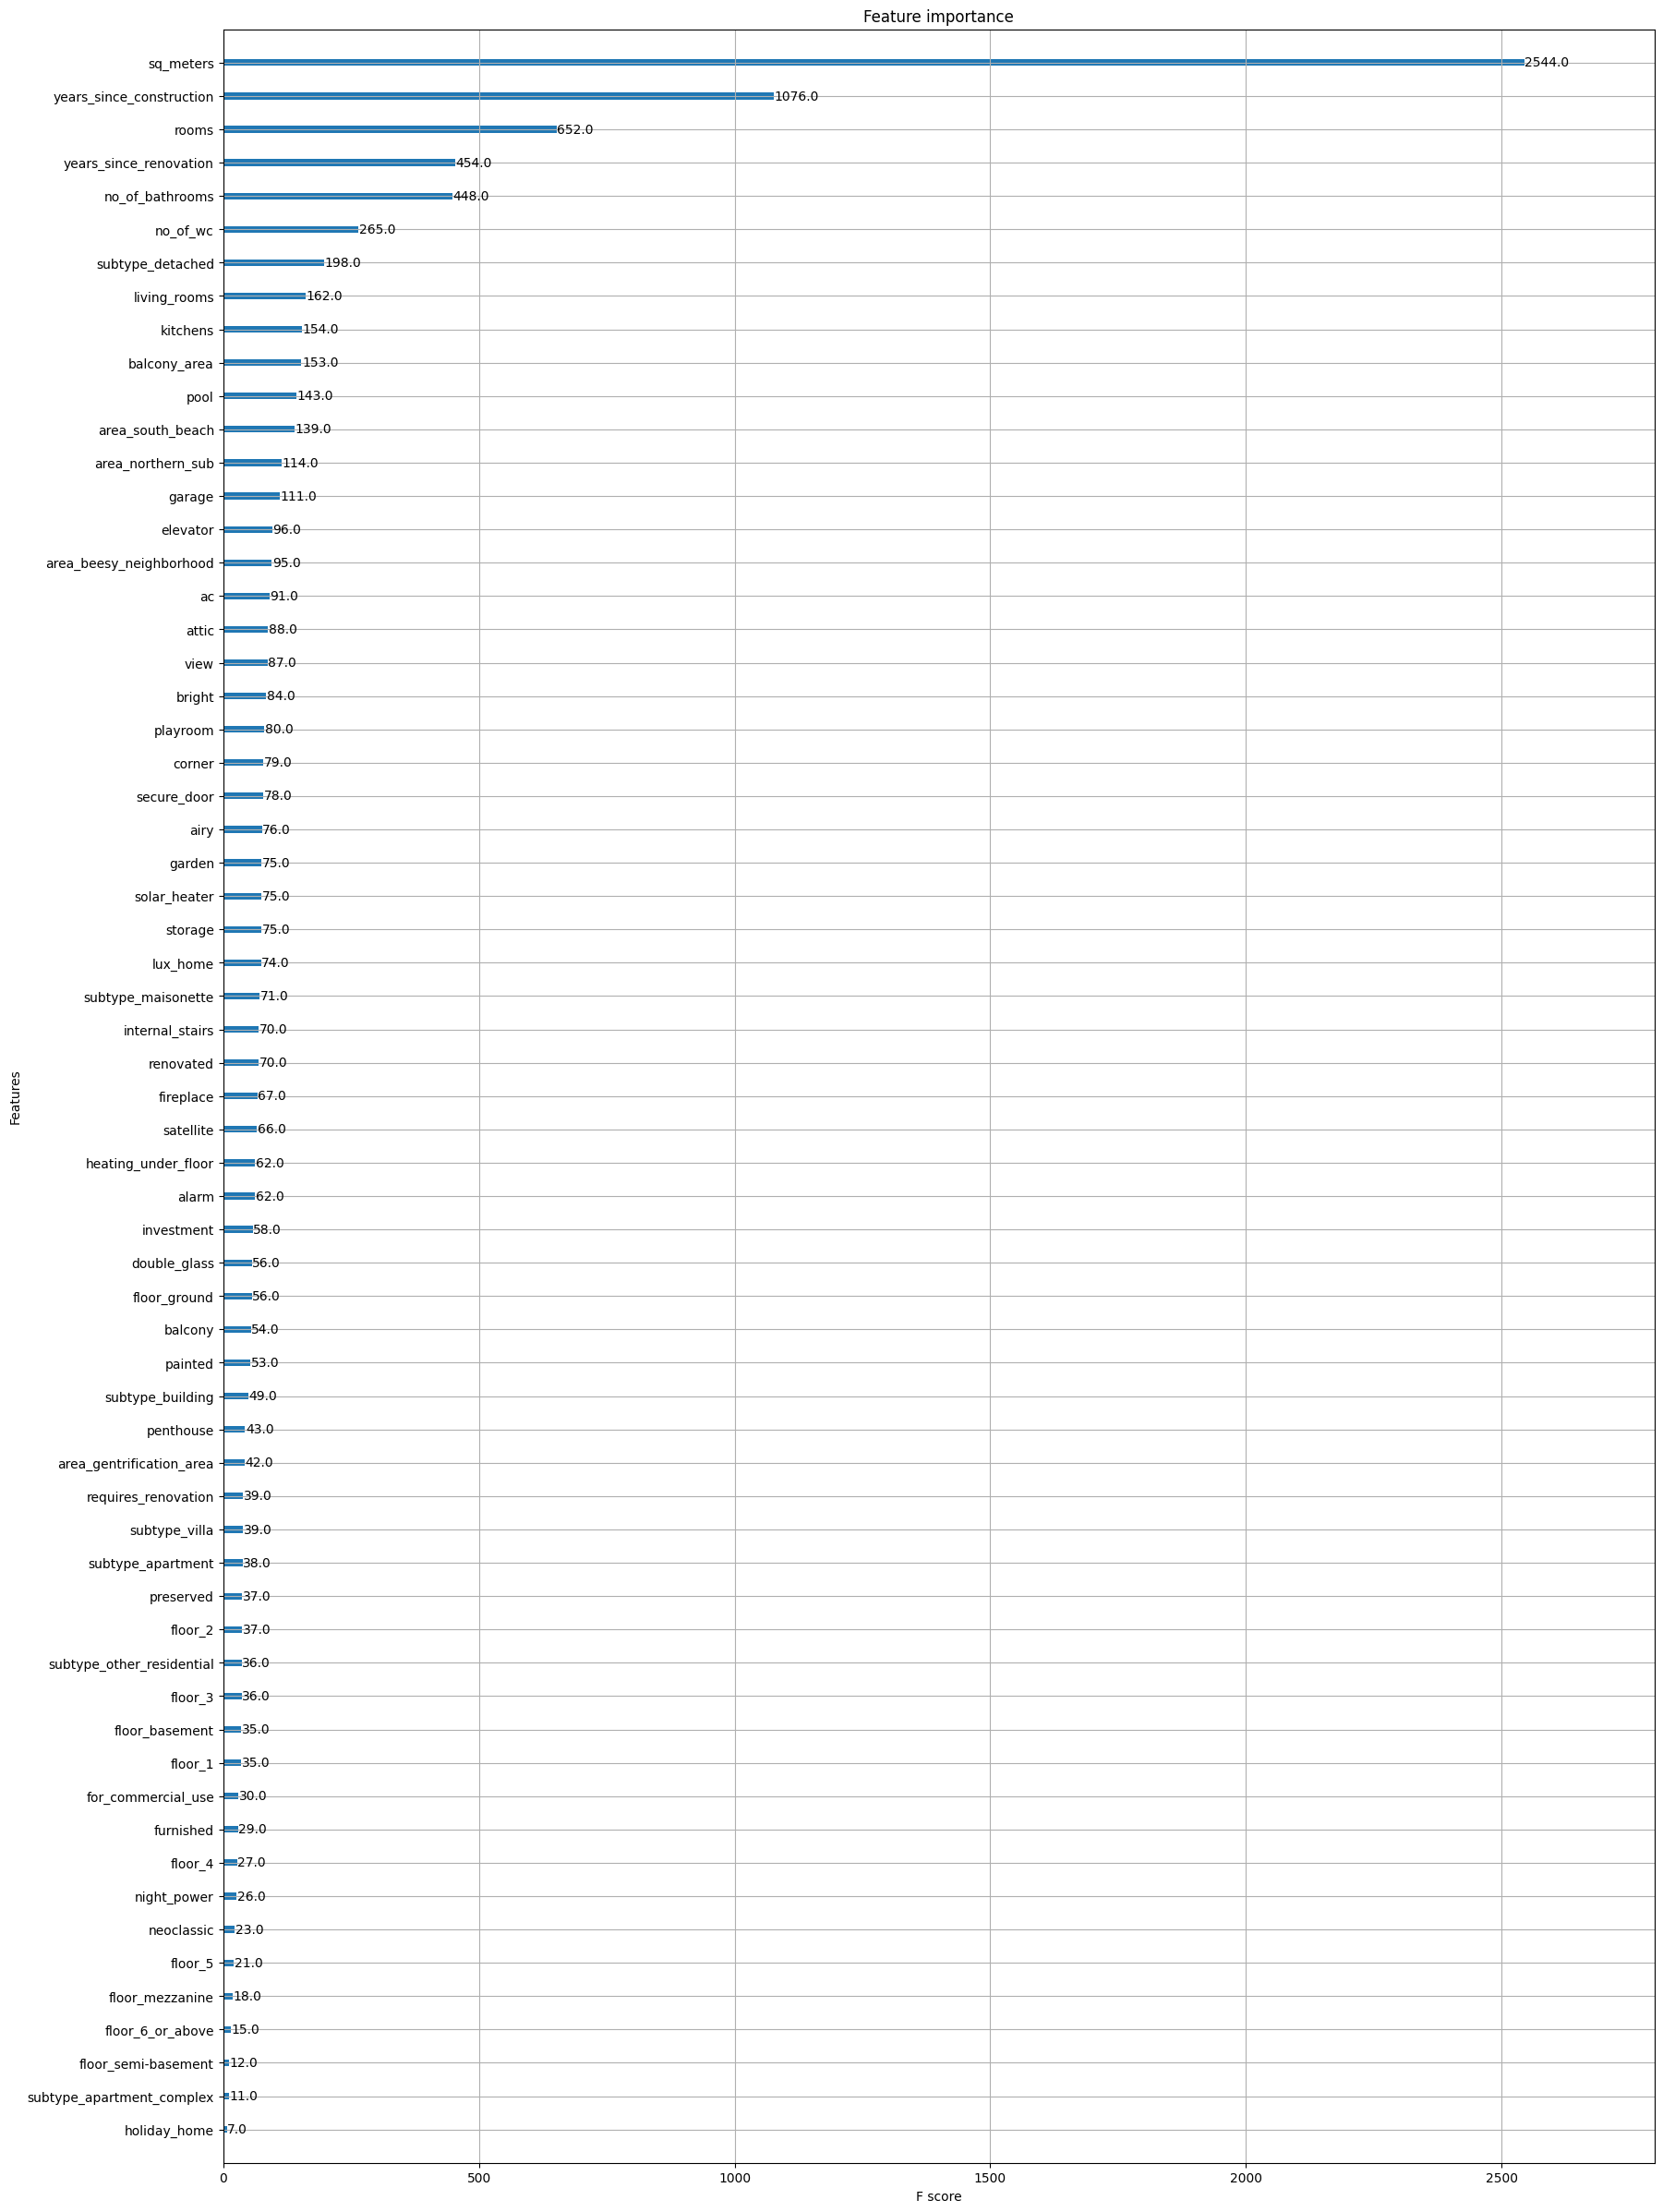

In [67]:
fig, ax = plt.subplots(figsize=(20, 30))
plot_importance(xgb, ax=ax)

plt.show()

### What to do if I had more time


- Some Diagnostics tests in order to find the reason that the model is overfitting the data. 
- Some further feature engineering (removing Outliers)
- Trying Regularized Polynomial/Linear Regression
- By accessing the coefficients of Linear Regression we would also get to know the feature importance (the higher the coefficient the more important the corresponding feature)

# The End